In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from ast import literal_eval
from sklearn.cluster import MeanShift, KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns

In [15]:
pd.options.display.max_rows = 500

In [46]:
schools = pd.read_csv('C:/Users/jbachlombardo/Documents/Community Colleges/Data/College scorecard/CollegeScorecard_Raw_Data/merged_all_scorecard_indicators_longitudinal_zips_fipsadj_RESET FROM HERE 051619_adjacent_counties.csv', index_col = 'UNITID')

In [47]:
schools = schools[[x for x in schools.columns if 'Unnamed:' not in x]]

In [410]:
usecols = pd.read_excel('C:/Users/jbachlombardo/Documents/Community Colleges/demos.xlsx', sheet_name = 'USECOLS')

In [411]:
usecols = list(usecols['COL'])

In [413]:
school_ids = [175643, 226107, 161688, 164313, 193326, 236887, 118912]

In [414]:
schools = schools.reset_index()

In [415]:
schools[schools['UNITID'].isin(school_ids)][usecols].T.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/demosccc.csv')

In [445]:
schools[usecols[9:]].T.to_csv('C:/Users/jbachlombardo/Documents/Community Colleges/demosccc_avgs.csv')

<b>CLUSTERING</b>

In [239]:
clustertest = schools[usecols]

In [240]:
clustertest['NUM ADJ SCHOOLS'] = clustertest['ADJ_SCHOOLS'].apply(lambda x: len(literal_eval(x)))

C:\Users\jbachlombardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [241]:
def ignore_na_len(x) :
    if x == 'xx' :
        return 0
    else :
        return len(literal_eval(x))

In [242]:
clustertest['NUM ADJ COUNTIES'] = clustertest['ADJ_COUNTIES_SCHOOLONLY'].fillna('xx').apply(ignore_na_len)

C:\Users\jbachlombardo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [243]:
clustertest = pd.concat([clustertest, pd.get_dummies(clustertest['LOCALE'], drop_first = True)], axis = 1)

In [244]:
dropcols = ['ADJ_SCHOOLS', 'ADJ_COUNTIES_SCHOOLONLY', 'INSTNM', 'CITY', 'County', 'FIPS', 'STABBR', 'LOCALE']

In [245]:
clustercols = [c for c in clustertest.set_index('UNITID').columns if c not in dropcols]

In [246]:
cluster_test_set = clustertest.set_index('UNITID')[clustercols].reset_index()

In [247]:
cluster_test_set = cluster_test_set.replace('PrivacySuppressed', np.nan)

In [248]:
cluster_test_set = cluster_test_set.replace(np.inf, np.nan)

In [249]:
for c in cluster_test_set :
    cluster_test_set[c] = cluster_test_set[c].astype(float)
    cluster_test_set[c] = cluster_test_set[c].fillna(cluster_test_set[c].median())

In [250]:
labels = cluster_test_set['UNITID']
X = cluster_test_set.iloc[:, 1:]

<b>K-MEANS</b>

In [370]:
k_model = Pipeline([('scale', StandardScaler()),
             ('cluster', KMeans(n_clusters = 7))])

In [371]:
k_groups = k_model.fit_predict(X)

In [372]:
kgroups = cluster_test_set.copy()

In [373]:
kgroups['Groups'] = k_groups
kgroups['Groups'].value_counts().sort_index()

0    216
1    214
2    156
3    171
4    401
5    150
6     41
Name: Groups, dtype: int64

In [374]:
k_corr = pd.concat([kgroups, pd.get_dummies(kgroups['Groups'])], axis = 1)

In [375]:
k_corr = k_corr.drop(['Groups', 'UNITID'], axis = 1)

In [376]:
kgroups.set_index('UNITID').groupby('Groups').mean()

,INEXPFTE,AVGFACSAL,PFTFAC,TUITIONFEE_IN,TUITIONFEE_OUT,Deg_created_5yrs,Deg_removed_5yr,Deg_created_10yrs,Deg_removed_10yr,Deg_created_15yrs,...,13.0,21.0,22.0,23.0,31.0,32.0,33.0,41.0,42.0,43.0
Groups,,,,,,,,,,,,,,,,,,,,,
0,5520.995370,8100.509259,0.422229,2353.611111,7852.370370,7.467593,16.402778,9.888889,15.847222,13.773148,...,0.083333,0.347222,0.041667,0.013889,0.000000,0.032407,0.018519,0.018519,0.004630,0.000000
1,5848.285047,6205.976636,0.515816,3655.214953,8436.359813,8.710280,12.182243,11.929907,10.130841,15.116822,...,0.144860,0.102804,0.046729,0.028037,0.018692,0.088785,0.042056,0.163551,0.037383,0.000000
2,7518.974359,6624.903846,0.579662,4719.006410,7678.756410,6.698718,9.435897,8.634615,8.429487,11.089744,...,0.141026,0.096154,0.012821,0.025641,0.019231,0.032051,0.282051,0.153846,0.032051,0.025641
3,10441.532164,6316.222222,0.407100,4004.631579,7701.140351,0.877193,2.187135,1.842105,2.286550,2.514620,...,0.070175,0.274854,0.035088,0.052632,0.046784,0.128655,0.064327,0.204678,0.046784,0.005848
4,6504.491272,5890.569825,0.518578,3515.137157,7603.533666,5.860349,10.384040,8.396509,9.725686,10.423940,...,0.109726,0.082294,0.024938,0.022444,0.027431,0.152120,0.114713,0.226933,0.077307,0.047382
5,7891.300000,6133.920000,0.437141,3654.766667,7434.566667,2.480000,4.286667,3.840000,4.353333,4.526667,...,0.080000,0.160000,0.040000,0.046667,0.006667,0.133333,0.120000,0.173333,0.073333,0.033333
6,6004.878049,6532.365854,0.398607,5715.585366,12565.926829,2.731707,4.317073,4.024390,4.024390,6.780488,...,0.000000,0.000000,0.024390,0.000000,0.000000,0.146341,0.024390,0.170732,0.000000,0.024390


In [377]:
silhouette_score(X, k_groups)

0.0251682277165014

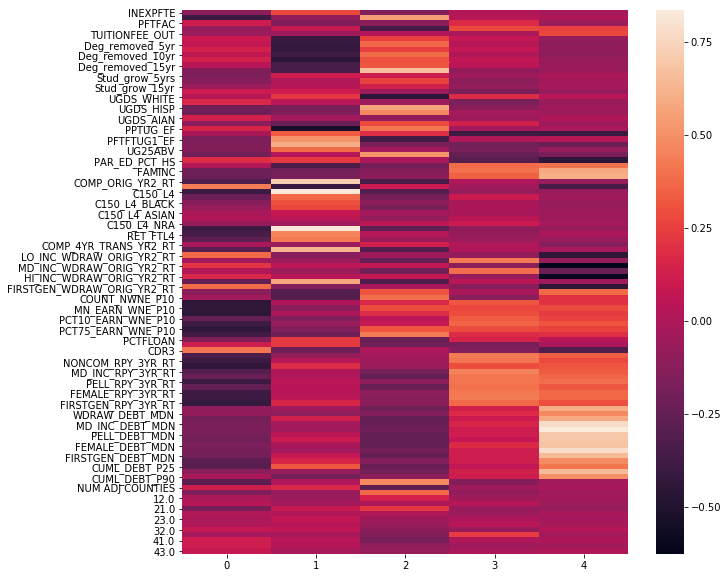

In [361]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(k_corr.corr().iloc[:-len(np.unique(k_groups)),-len(np.unique(k_groups)):], ax = ax)

In [395]:
silhouettes = {}
for n in np.arange(3, 15) :
    pipe = Pipeline([('scale', StandardScaler()),
             ('cluster', KMeans(n_clusters = n))])
    pipe_groups = pipe.fit_predict(X)
    silhouettes[n] = silhouette_score(X, pipe_groups)

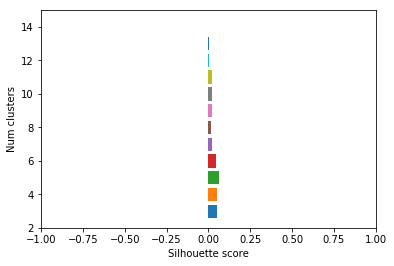

In [396]:
fig, ax = plt.subplots()
for k, v in silhouettes.items() :
    ax.barh(k, v)
ax.set_xlim(-1, 1)
ax.set_ylabel('Num clusters')
ax.set_xlabel('Silhouette score')
plt.show()

In [397]:
sample_weights_kmeans = np.ones(len(X.columns))
sample_weights_kmeans[-12:] = 1/len(X.columns[-12:])
X_weighted = X * sample_weights_kmeans

In [398]:
silhouettes_weighted = {}
for n in np.arange(3, 15) :
    pipe = Pipeline([('scale', StandardScaler()),
             ('cluster', KMeans(n_clusters = n))])
    pipe_groups = pipe.fit_predict(X_weighted)
    silhouettes_weighted[n] = silhouette_score(X_weighted, pipe_groups)

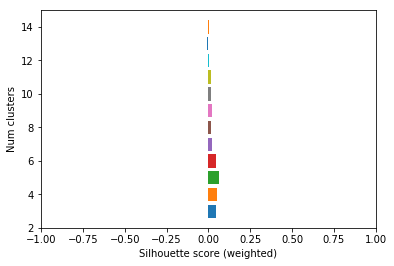

In [399]:
fig, ax = plt.subplots()
for k, v in silhouettes_weighted.items() :
    ax.barh(k, v)
ax.set_xlim(-1, 1)
ax.set_ylabel('Num clusters')
ax.set_xlabel('Silhouette score (weighted)')
plt.show()

<b>MEAN SHIFT</b>

In [378]:
ms = Pipeline([('scale', StandardScaler()),
             ('cluster', MeanShift())])

In [379]:
blobs = ms.fit_predict(X)

In [380]:
blobber = cluster_test_set.copy()

In [381]:
blobber['Blobs'] = blobs
blobber['Blobs'].value_counts().sort_index()

0    1293
1      35
2       2
3       1
4       1
5       1
6       2
7       2
8      11
9       1
Name: Blobs, dtype: int64

In [382]:
blob_corr = pd.concat([blobber, pd.get_dummies(blobber['Blobs'])], axis = 1)

In [383]:
blob_corr = blob_corr.drop('Blobs', axis = 1)

In [384]:
blobber.groupby('Blobs').mean()

,UNITID,INEXPFTE,AVGFACSAL,PFTFAC,TUITIONFEE_IN,TUITIONFEE_OUT,Deg_created_5yrs,Deg_removed_5yr,Deg_created_10yrs,Deg_removed_10yr,...,13.0,21.0,22.0,23.0,31.0,32.0,33.0,41.0,42.0,43.0
Blobs,,,,,,,,,,,,,,,,,,,,,
0,1.079614e+06,6986.132251,6474.577340,0.483188,3531.161640,7764.566899,5.654292,9.834493,7.873937,9.118329,...,0.106729,0.164733,0.033256,0.029389,0.020882,0.102088,0.100541,0.164733,0.047951,0.020882
1,1.303882e+07,6125.257143,6690.242857,0.401603,6207.485714,13723.400000,2.542857,3.942857,3.714286,3.828571,...,0.000000,0.000000,0.028571,0.000000,0.000000,0.142857,0.028571,0.114286,0.000000,0.028571
2,1.021795e+05,9155.000000,6190.750000,0.629500,6560.000000,11521.500000,1.500000,3.500000,1.000000,3.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,1.052060e+05,4110.000000,6290.000000,0.281300,2112.000000,6972.000000,14.000000,40.000000,20.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,1.178030e+05,30463.000000,9860.000000,1.000000,3702.000000,7625.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.509870e+05,3346.000000,5621.000000,0.263800,4175.000000,8052.000000,31.000000,6.000000,42.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,4.179875e+05,18630.500000,6307.500000,0.407100,9006.000000,11217.500000,0.000000,0.000000,0.500000,0.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,3.346565e+05,5404.500000,6307.500000,0.407100,3702.000000,7625.000000,1.500000,0.000000,2.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
8,2.353289e+05,7907.000000,6354.954545,0.712109,6217.818182,7706.636364,4.909091,6.636364,7.181818,5.727273,...,0.090909,0.090909,0.000000,0.000000,0.000000,0.090909,0.181818,0.363636,0.090909,0.000000


In [385]:
silhouette_score(X, blobs)

-0.3074151451117953

<b>TSNE</b>

In [319]:
tsne_array = scale(X)

In [320]:
tsne_model = TSNE(learning_rate = 100)

In [322]:
plot_samples = tsne_model.fit_transform(tsne_array)

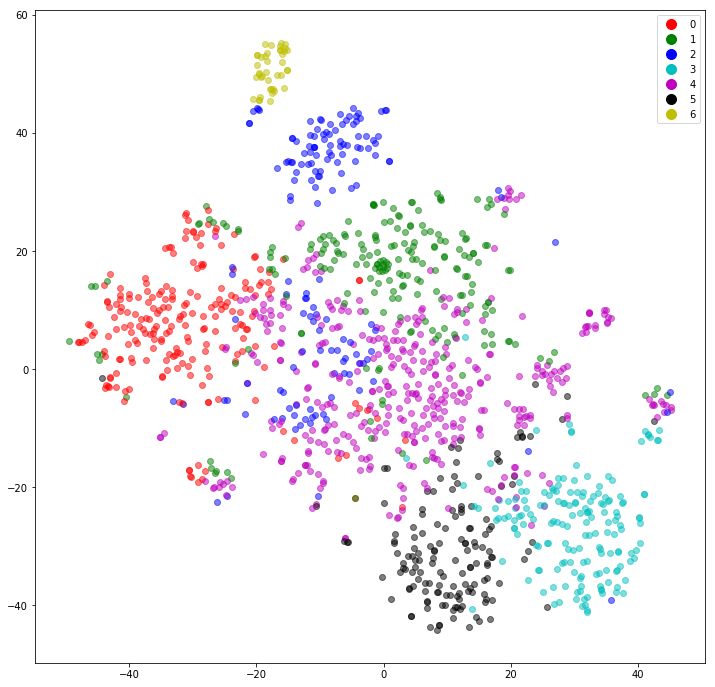

In [400]:
fig, ax = plt.subplots(figsize = (12, 12))
labels = k_groups #blobs
legend_labels = np.unique(labels)
mark = 20
colors = ['r', 'g', 'b', 'c', 'm', 'k', 'y', 'orange', 'crimson', 'magenta', 'darkgrey', 'tan', 'lightpink', 'lime']
handles_dict = {}
for i in range(len(legend_labels)) :
    k = 'dot_' + str(i)
    handles_dict[k] = mlines.Line2D([], [], linestyle = 'None', color=colors[legend_labels[i]], marker='.', markersize=mark, label=legend_labels[i])
for i in range(len(plot_samples)) :
    ax.scatter(plot_samples[i, 0], plot_samples[i, 1], c = colors[labels[i]], alpha = 0.5)
plt.legend(handles=[v for k, v in handles_dict.items()])
plt.show()

In [343]:
writer = pd.ExcelWriter('C:/Users/jbachlombardo/Documents/Community Colleges/Data/Clustering results/kmeans_3groups_051619.xlsx')
kgroups.to_excel(writer, sheet_name = 'Groups - raw')
kgroups.set_index('UNITID').groupby('Groups').mean().to_excel(writer, sheet_name = 'Groups - averages')
writer.close()